In [9]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm


# Datasets

## Geo

In [2]:
bel = pd.read_csv('https://raw.githubusercontent.com/mathiasleroy/Belgium-Geographic-Data/master/dist/metadata/be-dictionary.csv', encoding = 'latin1')
bel = bel[['NIS5', 'Province']]
bel.columns = ['NIS5', 'PROVINCE']
bel['NIS5'] = bel['NIS5'].astype(str)
bel = bel.drop_duplicates()
bel = bel.replace({
    'Brussels': 'Brussel',
    'Brabant Wallon': 'Waals-Brabant',
    'Hainaut': 'Henegouwen',
    'Liège': 'Luik',
    'Luxembourg': 'Luxemburg',
    'Namur': 'Namen'
})
bel.head()

,NIS5,PROVINCE
0,11001,Antwerpen
16,11002,Antwerpen
353,11004,Antwerpen
373,11005,Antwerpen
392,11007,Antwerpen


In [3]:
inw = pd.read_csv('resources/inwoners.csv', sep = ';')
inw.head()

,PROVINCE,INHAB
0,Oost-Vlaanderen,1516000
1,West-Vlaanderen,1197000
2,Vlaams-Brabant,1147000
3,Limburg,875842
4,Antwerpen,1860000


## Besmettingen

In [4]:
inf = pd.read_csv('resources/COVID19BE_CASES_AGESEX.csv', parse_dates = ['DATE'], date_parser = lambda x: pd.to_datetime(x, format='%Y-%m-%d'))
inf['WEEK'] = inf['DATE'].dt.isocalendar().week
inf['YEAR'] = inf['DATE'].dt.year
inf = inf.groupby(['YEAR', 'WEEK','PROVINCE']).agg({'CASES': sum}).reset_index()
inf['WEEK'] = inf['WEEK'].astype(int)
inf['YEAR'] = inf['YEAR'].astype(int)
inf['PROVINCE'] = inf['PROVINCE'].replace({
    'Brussels': 'Brussel',
    'Liège': 'Luik',
    'OostVlaanderen': 'Oost-Vlaanderen',
    'WestVlaanderen': 'West-Vlaanderen',
    'BrabantWallon': 'Waals-Brabant',
    'Hainaut': 'Henegouwen',
    'Luxembourg': 'Luxemburg',
    'Namur': 'Namen',
    'VlaamsBrabant': 'Vlaams-Brabant'
})
inf = inf.sort_values(['YEAR', 'WEEK', 'PROVINCE'])
inf.loc[inf.WEEK == 53,'WEEK'] = 0
inf.tail(20)

,YEAR,WEEK,PROVINCE,CASES
1010,2021,48,Henegouwen,2704
1011,2021,48,Limburg,2737
1012,2021,48,Luik,2784
1013,2021,48,Luxemburg,742
1014,2021,48,Namen,1262
1015,2021,48,Oost-Vlaanderen,5339
1016,2021,48,Vlaams-Brabant,3340
1008,2021,48,Waals-Brabant,1065
1017,2021,48,West-Vlaanderen,4390
1018,2021,0,Antwerpen,416


## Hospitalisaties

In [5]:
hos = pd.read_csv('resources/COVID19BE_HOSP.csv', parse_dates = ['DATE'], date_parser = lambda x: pd.to_datetime(x, format='%Y-%m-%d'))
hos = hos.replace({
    'Brussels': 'Brussel',
    'Liège': 'Luik',
    'OostVlaanderen': 'Oost-Vlaanderen',
    'WestVlaanderen': 'West-Vlaanderen',
    'BrabantWallon': 'Waals-Brabant',
    'Hainaut': 'Henegouwen',
    'Luxembourg': 'Luxemburg',
    'Namur': 'Namen',
    'VlaamsBrabant': 'Vlaams-Brabant'
})
hos['WEEK'] = hos['DATE'].dt.isocalendar().week
hos['YEAR'] = hos['DATE'].dt.year
hos = hos.groupby(['YEAR', 'WEEK', 'PROVINCE']).sum().reset_index()
hos = hos[['WEEK', 'YEAR', 'PROVINCE', 'NR_REPORTING', 'TOTAL_IN', 'TOTAL_IN_ICU']]
hos.columns = ['WEEK', 'YEAR', 'PROVINCE', 'HOSP_IN', 'HOSP_ALL', 'HOSP_ALL_ICU']
hos = hos.sort_values(['YEAR', 'WEEK', 'PROVINCE'])
hos.loc[hos.WEEK == 53,'WEEK'] = 0
hos.tail(30)

,WEEK,YEAR,PROVINCE,HOSP_IN,HOSP_ALL,HOSP_ALL_ICU
982,47,2021,Limburg,49,1910,393
983,47,2021,Luik,84,3049,594
984,47,2021,Luxemburg,21,475,121
985,47,2021,Namen,42,788,201
986,47,2021,Oost-Vlaanderen,98,3530,696
987,47,2021,Vlaams-Brabant,42,1213,286
988,47,2021,Waals-Brabant,14,279,57
989,47,2021,West-Vlaanderen,77,3167,582
990,48,2021,Antwerpen,42,1703,339
991,48,2021,Brussel,45,1270,283


## Vaccinaties

In [6]:
vac = pd.read_csv('resources/COVID19BE_VACC_MUNI_CUM.csv', na_values = '<10')
vac['YEAR'] = vac['YEAR_WEEK'].apply(lambda x: '20' + x[:2]).astype(int)
vac['WEEK'] = vac['YEAR_WEEK'].apply(lambda x: x[3:5]).astype(int)
vac = vac.dropna()
vac['NIS5'] = vac['NIS5'].astype(int).astype(str)
vac = vac.groupby(['YEAR', 'WEEK', 'NIS5', 'DOSE']).agg({'CUMUL': sum}).reset_index()
vac.columns = ['YEAR', 'WEEK', 'NIS5', 'DOSE', 'VACCINATIONS']
vac.loc[vac.WEEK == 53,'WEEK'] = 0

vac.head()

,YEAR,WEEK,NIS5,DOSE,VACCINATIONS
0,2020,0,12041,A,95.0
1,2020,0,21019,A,39.0
2,2020,0,23103,A,34.0
3,2020,0,24062,A,160.0
4,2020,0,24066,A,40.0


In [55]:
df = vac.merge(bel, on = 'NIS5', how = 'left')
df = df.groupby(['YEAR', 'WEEK', 'PROVINCE','DOSE']).agg({'VACCINATIONS': sum}).reset_index()
df = df.pivot_table(values = 'VACCINATIONS', index = ['YEAR', 'WEEK', 'PROVINCE'], columns = 'DOSE').reset_index()
df = df.rename({'A': 'DOSIS_A', 'B': 'DOSIS_B', 'C': 'DOSIS_C'}, axis = 1)
df['DOSIS_FULL'] = df['DOSIS_B'] + df['DOSIS_C']
df = df.merge(inf, on = ['YEAR', 'WEEK', 'PROVINCE'], how = 'right')
df = df.merge(hos, on = ['YEAR', 'WEEK', 'PROVINCE'], how = 'left')
df = df.merge(inw, on = 'PROVINCE', how = 'left')

df['VAC_RATE'] = df['DOSIS_FULL'] / df['INHAB']
df['HOSP_RATE_10K'] = df['HOSP_ALL'] / df['INHAB'] * 100000
df['CASES_ROLL_28'] = df.groupby(['PROVINCE'])['CASES'].rolling(4).sum().reset_index(0,drop=True)
df['HOSP_CASE_RATE_1K'] = df['HOSP_ALL'] / df['CASES_ROLL_28'] * 1000

df = df[df.YEAR == 2021]
df = df[df.WEEK <= 47]
df = df[df.WEEK > 15]
df.tail(15)

,YEAR,WEEK,PROVINCE,DOSIS_A,DOSIS_B,DOSIS_C,DOSIS_FULL,CASES,HOSP_IN,HOSP_ALL,HOSP_ALL_ICU,INHAB,VAC_RATE,HOSP_RATE_10K,CASES_ROLL_28,HOSP_CASE_RATE_1K
992,2021,46,Oost-Vlaanderen,1111100.0,1098630.0,52120.0,1150750.0,19289,98.0,2482.0,524.0,1516000,0.759070,163.720317,43089.0,57.601708
993,2021,46,Vlaams-Brabant,872836.0,862607.0,50956.0,913563.0,10621,42.0,995.0,237.0,1147000,0.796480,86.748038,27810.0,35.778497
994,2021,46,Waals-Brabant,298828.0,292391.0,5453.0,297844.0,3144,14.0,239.0,54.0,404270,0.736745,59.118906,9773.0,24.455131
995,2021,46,West-Vlaanderen,958801.0,949462.0,47987.0,997449.0,17096,77.0,3012.0,471.0,1197000,0.833291,251.629073,42711.0,70.520475
996,2021,47,Antwerpen,1400917.0,1383425.0,66686.0,1450111.0,22239,98.0,3439.0,688.0,1860000,0.779630,184.892473,65613.0,52.413394
997,2021,47,Brussel,673258.0,651621.0,51168.0,702789.0,8457,105.0,3030.0,592.0,1209000,0.581298,250.620347,25361.0,119.474784
998,2021,47,Henegouwen,722132.0,708300.0,26911.0,735211.0,10148,98.0,3085.0,527.0,1346000,0.546219,229.197623,29630.0,104.117449
999,2021,47,Limburg,637754.0,629769.0,36660.0,666429.0,11421,49.0,1910.0,393.0,875842,0.760901,218.075863,32759.0,58.304588
1000,2021,47,Luik,752894.0,735041.0,19926.0,754967.0,8878,84.0,3049.0,594.0,1110000,0.680150,274.684685,29765.0,102.435747
1001,2021,47,Luxemburg,205638.0,200742.0,2648.0,203390.0,2814,21.0,475.0,121.0,286950,0.708799,165.534065,8518.0,55.764264


<AxesSubplot:title={'center':'Aantal gehospitaliseerden per 1000 besmettingen (Week 30-47, 2021)'}, xlabel='Week', ylabel='Aantal gehospitaliseerden per 1000 besmettingen (in de laatste 28 dagen)'>

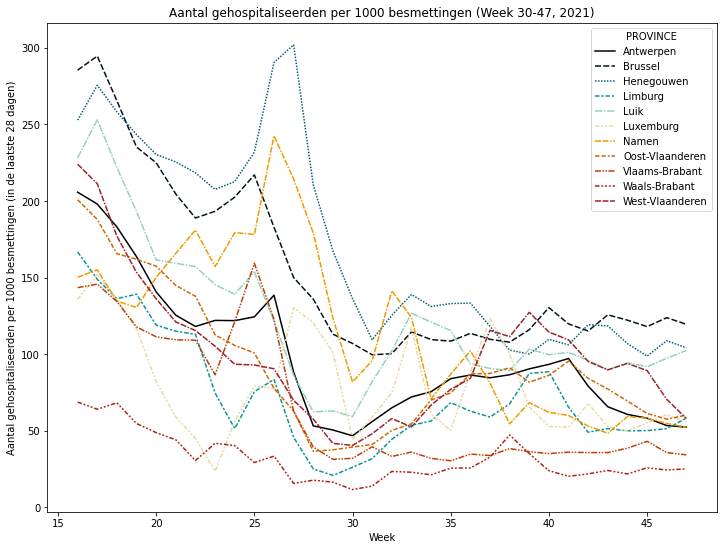

In [56]:
pal = sns.color_palette(['#000000', '#001219', '#005f73', '#0a9396', '#94d2bd', '#e9d8a6', '#ee9b00', '#ca6702', '#bb3e03','#ae2012', '#9b2226'], 11)
p = sns.lineplot(x = 'WEEK', y = 'HOSP_CASE_RATE_1K', hue = 'PROVINCE', style = 'PROVINCE', data = df, palette = pal)
p.set_xlabel('Week')
p.set_ylabel('Aantal gehospitaliseerden per 1000 besmettingen (in de laatste 28 dagen)')
p.set_title('Aantal gehospitaliseerden per 1000 besmettingen (Week 30-47, 2021)')
p

Text(0.5, 1.0, 'Vaccinatiegraad vs. hospitalisatiegraad (Week 47, 2021)')

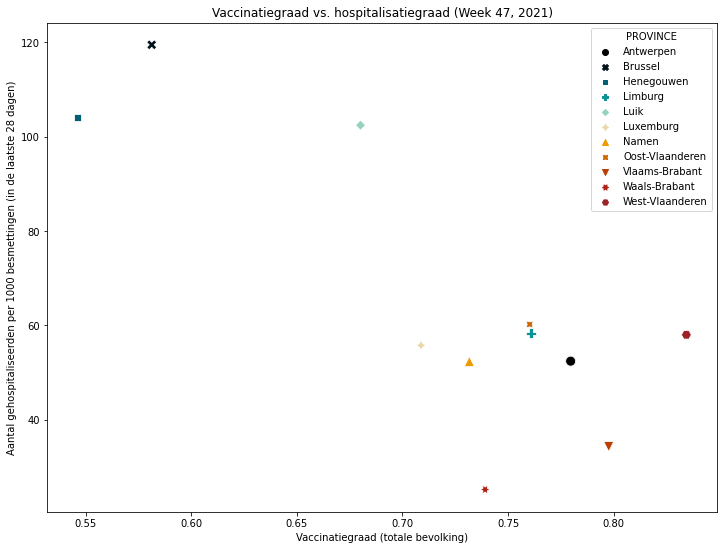

In [41]:
plt.rcParams["figure.figsize"] = (12,9)
p = sns.scatterplot(x = 'VAC_RATE', y = 'HOSP_CASE_RATE_1K', data = df[df.WEEK == 47], hue = 'PROVINCE', style = 'PROVINCE', s = 100, palette = pal)
p.set_xlabel('Vaccinatiegraad (totale bevolking)')
p.set_ylabel('Aantal gehospitaliseerden per 1000 besmettingen (in de laatste 28 dagen)')
p.set_title('Vaccinatiegraad vs. hospitalisatiegraad (Week 47, 2021)')

<AxesSubplot:title={'center':'Vaccinatiegraad vs. hospitalisatiegraad'}, xlabel='Vaccinatiegraad (totale bevolking)', ylabel='Aantal gehospitaliseerden per 1000 besmettingen (in de laatste 28 dagen)'>

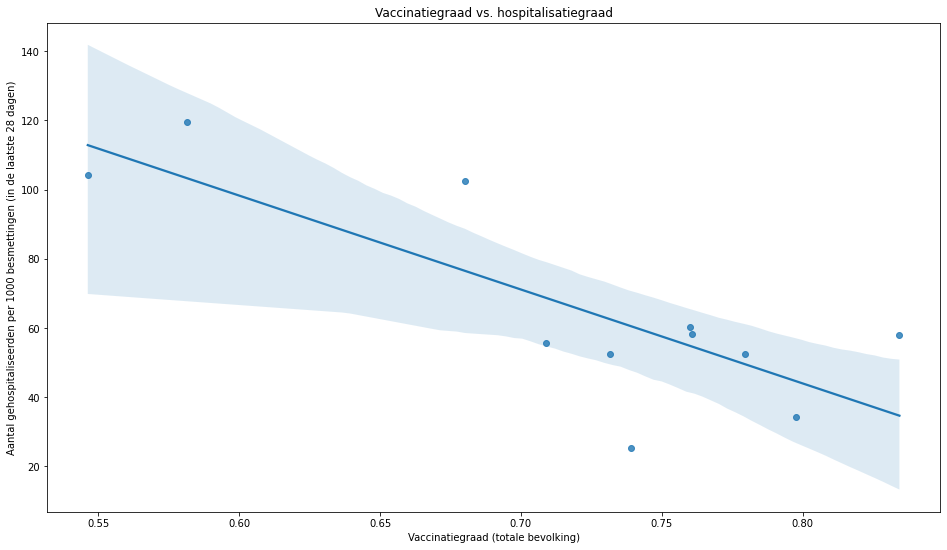

In [38]:
p = sns.regplot(x = 'VAC_RATE', y = 'HOSP_CASE_RATE_1K', data = df[df.WEEK == 47])
p.set_xlabel('Vaccinatiegraad (totale bevolking)')
p.set_ylabel('Aantal gehospitaliseerden per 1000 besmettingen (in de laatste 28 dagen)')
p.set_title('Vaccinatiegraad vs. hospitalisatiegraad')
p

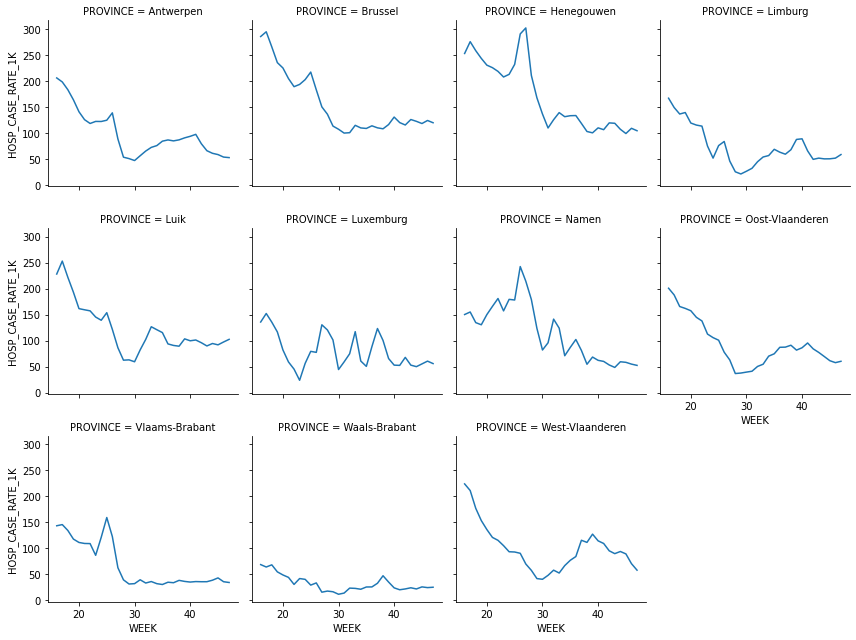

In [57]:
f = sns.FacetGrid(data = df, col = 'PROVINCE', col_wrap = 4)
f.map(sns.lineplot, 'WEEK', 'HOSP_CASE_RATE_1K')